sign-up at https://www.mapbox.com/

In [1]:
!pip install requests pillow matplotlib numpy geopy

Defaulting to user installation because normal site-packages is not writeable


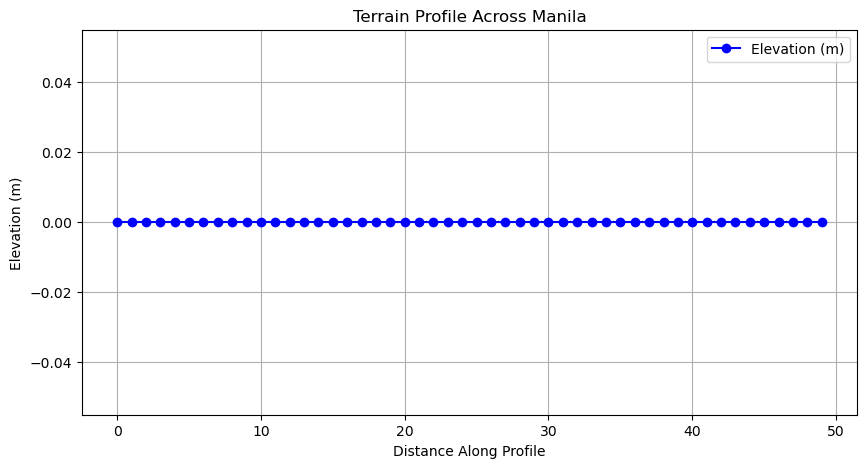

In [3]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO

# Replace with your Mapbox API Key
MAPBOX_ACCESS_TOKEN = "pk.eyJ1IjoiYWxiZXJ0cGFtb25hZyIsImEiOiJjbDJsa3d1M3kwb2VtM2Nwa2Vxajd1MDdsIn0.GQx5HParNf5Ba4AngkoBAw"

# Function to get elevation data from Mapbox Terrain-RGB
def get_elevation(lat, lon, zoom=14):
    url = f"https://api.mapbox.com/v4/mapbox.terrain-rgb/{zoom}/{lon},{lat}.pngraw?access_token={MAPBOX_ACCESS_TOKEN}"
    response = requests.get(url)

    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        r, g, b = img.getpixel((0, 0))  # Extract RGB from the image
        elevation = (r * 256 * 256 + g * 256 + b) * 0.1 - 10000  # Convert RGB to elevation
        return elevation
    else:
        return None

# Define a transect line (Example: Across Manila)
latitudes = np.linspace(14.55, 14.65, num=50)  # From South to North
longitudes = np.linspace(120.95, 121.05, num=50)  # From West to East

# Fetch elevations along the transect
elevations = [get_elevation(lat, lon) for lat, lon in zip(latitudes, longitudes)]

# Filter out None values if any requests fail
elevations = [e if e is not None else 0 for e in elevations]

# Plot terrain profile
plt.figure(figsize=(10, 5))
plt.plot(range(len(elevations)), elevations, marker='o', linestyle='-', color='b', label="Elevation (m)")
plt.xlabel("Distance Along Profile")
plt.ylabel("Elevation (m)")
plt.title("Terrain Profile Across Manila")
plt.legend()
plt.grid(True)
plt.show()


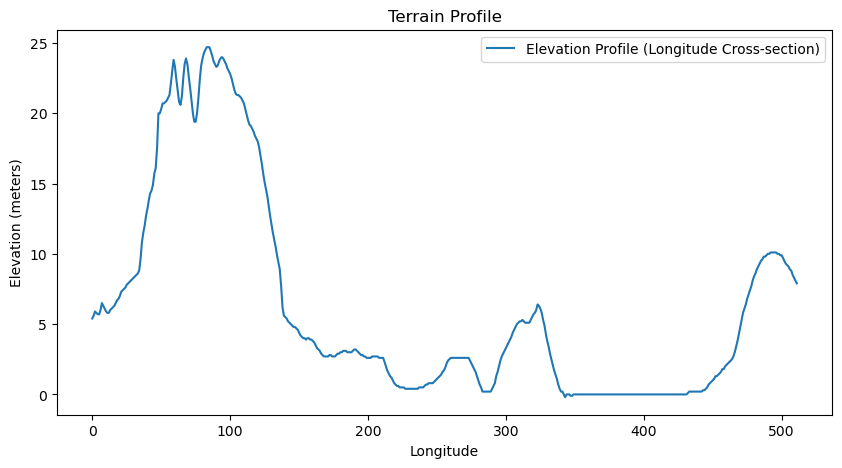

In [1]:
import requests
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
import math

# Mapbox Access Token
MAPBOX_ACCESS_TOKEN = 'pk.eyJ1IjoiYWxiZXJ0cGFtb25hZyIsImEiOiJjbDJsa3d1M3kwb2VtM2Nwa2Vxajd1MDdsIn0.GQx5HParNf5Ba4AngkoBAw'

# Function to convert lat/lon to tile indices
def lat_lon_to_tile_indices(lat, lon, zoom):
    x_tile = int((lon + 180) / 360 * (2 ** zoom))
    y_tile = int((1 - math.log(math.tan(math.radians(lat)) + 1 / math.cos(math.radians(lat))) / math.pi) / 2 * (2 ** zoom))
    return x_tile, y_tile

# Coordinates and zoom level
lat1, lon1 = 40.7128, -74.0060  # New York City
zoom = 12

# Convert lat/lon to tile indices
x_tile, y_tile = lat_lon_to_tile_indices(lat1, lon1, zoom)

# Construct the API URL
url = f'https://api.mapbox.com/v4/mapbox.terrain-rgb/{zoom}/{x_tile}/{y_tile}@2x.pngraw?access_token={MAPBOX_ACCESS_TOKEN}'

# Fetch the image
response = requests.get(url)

# Check response status
if response.status_code == 200:
    # Open the image
    image = Image.open(BytesIO(response.content))
    terrain_data = np.array(image)
   
    # Extract RGB channels
    r, g, b = terrain_data[:, :, 0], terrain_data[:, :, 1], terrain_data[:, :, 2]
   
    # Decode elevation
    elevation = -10000 + (r * 256**2 + g * 256 + b) * 0.1
   
    # Plot the terrain profile along the latitude or longitude
    plt.figure(figsize=(10, 5))
    plt.plot(elevation[0, :], label="Elevation Profile (Longitude Cross-section)")
    plt.title("Terrain Profile")
    plt.xlabel("Longitude")
    plt.ylabel("Elevation (meters)")
    plt.legend()
    plt.show()
else:
    print(f"Failed to retrieve data: {response.status_code}")

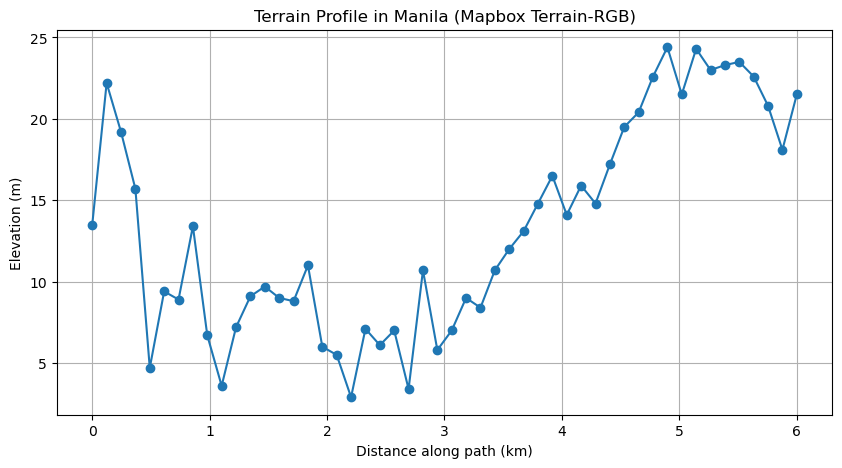

In [5]:
import math
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------
MAPBOX_ACCESS_TOKEN = "pk.eyJ1IjoiYWxiZXJ0cGFtb25hZyIsImEiOiJjbDJsa3d1M3kwb2VtM2Nwa2Vxajd1MDdsIn0.GQx5HParNf5Ba4AngkoBAw"
# Choose a zoom level. Higher zoom => finer spatial resolution but more tiles needed.
ZOOM_LEVEL = 13

# Define a start and end coordinate (lat, lon) in or near Manila for the cross-section.
start_lat, start_lon = 14.6000, 120.9790
end_lat, end_lon = 14.6500, 121.0000

# Number of sample points along the profile
NUM_SAMPLES = 50

# -----------------------------------------------------------------------------
# HELPER FUNCTIONS
# -----------------------------------------------------------------------------

def latlon_to_tile_indices(lat, lon, zoom):
    """
    Convert latitude/longitude to XYZ tile indices at a given zoom level.
    Formula reference:
    https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Derivation_of_tile_names
    """
    lat_rad = math.radians(lat)
    n = 2.0 ** zoom
    x_tile = int((lon + 180.0) / 360.0 * n)
    y_tile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return x_tile, y_tile

def latlon_to_pixel_in_tile(lat, lon, zoom, tile_size=256):
    """
    Given lat/lon at a certain zoom level, find:
      1) The tile indices (x_tile, y_tile)
      2) The pixel coordinates (px, py) within that tile

    The tile's pixel coordinates range from 0..255 in x and 0..255 in y.
    """
    lat_rad = math.radians(lat)
    n = 2.0 ** zoom

    # Continuous tile coordinates (float)
    x = (lon + 180.0) / 360.0 * n
    y = (1.0 - math.log(math.tan(lat_rad) + 1.0 / math.cos(lat_rad)) / math.pi) / 2.0 * n

    # Tile indices (integer)
    x_tile = int(x)
    y_tile = int(y)

    # Pixel positions within that tile
    x_px = int((x - x_tile) * tile_size)
    y_px = int((y - y_tile) * tile_size)

    return x_tile, y_tile, x_px, y_px

def fetch_terrain_rgb_tile(x_tile, y_tile, zoom):
    """
    Fetch a Terrain-RGB tile from Mapbox. 
    Tileset reference: mapbox.terrain-rgb
    The returned image is in Terrain-RGB format where each pixel 
    encodes elevation.
    """
    url = (
        f"https://api.mapbox.com/v4/mapbox.terrain-rgb/"
        f"{zoom}/{x_tile}/{y_tile}@2x.pngraw"
        f"?access_token={MAPBOX_ACCESS_TOKEN}"
    )
    response = requests.get(url)
    response.raise_for_status()  # Raise an error if the request failed
    return Image.open(BytesIO(response.content))

def terrain_rgb_to_elevation(r, g, b):
    """
    Decode the Terrain-RGB values into elevation in meters.
    According to Mapbox docs:
      E = (R * 256^2 + G * 256 + B) * 0.1 - 10000
    """
    return (r * 256 * 256 + g * 256 + b) * 0.1 - 10000

# -----------------------------------------------------------------------------
# MAIN LOGIC
# -----------------------------------------------------------------------------

def main():
    # Generate lat/lon sample points along a straight line between start and end
    lats = np.linspace(start_lat, end_lat, NUM_SAMPLES)
    lons = np.linspace(start_lon, end_lon, NUM_SAMPLES)

    distances = []   # Distances from start (km)
    elevations = []  # Elevation at each sample (meters)
    
    # Pre-fetch dictionary: (x_tile, y_tile) -> Pillow Image object
    tile_cache = {}

    # To track distance along the line, we need a helper function
    def haversine(lat1, lon1, lat2, lon2):
        R = 6371.0  # Earth radius in km
        d_lat = math.radians(lat2 - lat1)
        d_lon = math.radians(lon2 - lon1)
        a = math.sin(d_lat / 2) ** 2 + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(d_lon / 2) ** 2
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
        return R * c

    for i in range(NUM_SAMPLES):
        lat = lats[i]
        lon = lons[i]

        # Distance from the very first sample
        if i == 0:
            dist = 0.0
        else:
            dist = distances[-1] + haversine(lats[i-1], lons[i-1], lat, lon)
        distances.append(dist)

        # Figure out which tile we need
        x_tile, y_tile, x_px, y_px = latlon_to_pixel_in_tile(lat, lon, ZOOM_LEVEL)

        # Fetch from cache or request if not present
        if (x_tile, y_tile) not in tile_cache:
            tile_cache[(x_tile, y_tile)] = fetch_terrain_rgb_tile(x_tile, y_tile, ZOOM_LEVEL)

        tile_img = tile_cache[(x_tile, y_tile)]

        # Ensure we're within bounds. If using @2x tiles, tile_img is 512x512, so scale x_px, y_px accordingly.
        # Because we used `@2x.pngraw`, each tile is actually 512 x 512 pixels.
        # So multiply x_px and y_px by 2.
        x_px_2x = min(x_px * 2, 511)
        y_px_2x = min(y_px * 2, 511)

        r, g, b, _ = tile_img.getpixel((x_px_2x, y_px_2x))
        elevation_m = terrain_rgb_to_elevation(r, g, b)
        elevations.append(elevation_m)

    # Plot the profile
    plt.figure(figsize=(10, 5))
    plt.plot(distances, elevations, marker='o')
    plt.title("Terrain Profile in Manila (Mapbox Terrain-RGB)")
    plt.xlabel("Distance along path (km)")
    plt.ylabel("Elevation (m)")
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()


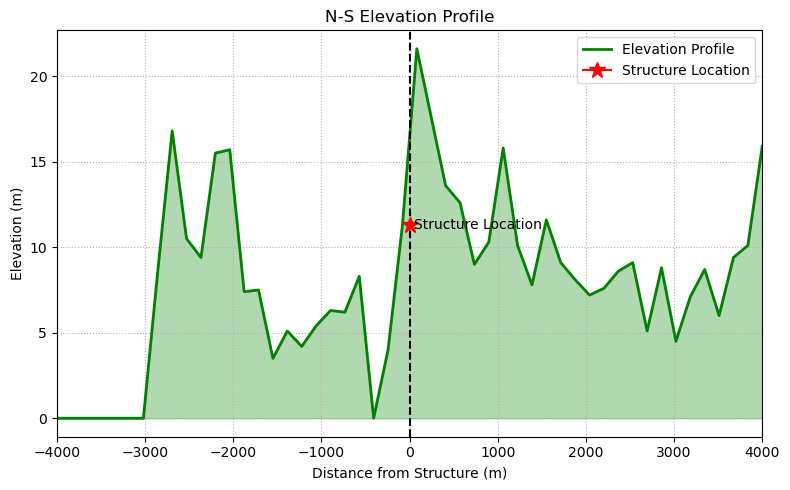

In [6]:
import math
import requests
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------------------------------------------------------
# 1) CONFIGURATION
# -----------------------------------------------------------------------------
MAPBOX_ACCESS_TOKEN = "pk.eyJ1IjoiYWxiZXJ0cGFtb25hZyIsImEiOiJjbDJsa3d1M3kwb2VtM2Nwa2Vxajd1MDdsIn0.GQx5HParNf5Ba4AngkoBAw"  # <-- Provide your token here

# Structure location (example: somewhere in Manila)
structure_lat = 14.6000
structure_lon = 120.9800

# Cross-section parameters: about ±4 km from the structure, north-south direction
cross_section_length_m = 4000  # distance on either side (in meters)
num_samples = 50               # number of sample points from -4 km to +4 km

# Mapbox tile zoom level (terrain detail). Adjust if needed.
zoom_level = 13

# -----------------------------------------------------------------------------
# 2) HELPER FUNCTIONS
# -----------------------------------------------------------------------------

def latlon_to_tile_indices(lat, lon, zoom):
    """
    Convert latitude/longitude to tile (x, y) indices at a given zoom level.
    Reference:
    https://wiki.openstreetmap.org/wiki/Slippy_map_tilenames#Derivation_of_tile_names
    """
    lat_rad = math.radians(lat)
    n = 2.0 ** zoom
    x_tile = int((lon + 180.0) / 360.0 * n)
    y_tile = int((1.0 - math.log(math.tan(lat_rad) + (1 / math.cos(lat_rad))) / math.pi) / 2.0 * n)
    return x_tile, y_tile

def latlon_to_pixel_in_tile(lat, lon, zoom, tile_size=256):
    """
    Given lat/lon at a certain zoom level, returns:
      1) The tile indices (x_tile, y_tile)
      2) The pixel coordinates (px, py) within that tile.
    Because we use "@2x" tiles below, note that each tile is effectively 512×512 in actual pixels.
    """
    lat_rad = math.radians(lat)
    n = 2.0 ** zoom

    x = (lon + 180.0) / 360.0 * n
    y = (1.0 - math.log(math.tan(lat_rad) + 1.0 / math.cos(lat_rad)) / math.pi) / 2.0 * n

    x_tile = int(x)
    y_tile = int(y)

    # Pixel position within the tile (0..255 if tile_size=256)
    x_px = int((x - x_tile) * tile_size)
    y_px = int((y - y_tile) * tile_size)

    return x_tile, y_tile, x_px, y_px

def fetch_terrain_rgb_tile(x_tile, y_tile, zoom):
    """
    Fetch a Terrain-RGB tile (PNG) from Mapbox’s terrain-rgb tileset at the specified zoom level.
    We request @2x.pngraw for double-resolution tiles (512×512).
    """
    url = (
        f"https://api.mapbox.com/v4/mapbox.terrain-rgb/"
        f"{zoom}/{x_tile}/{y_tile}@2x.pngraw"
        f"?access_token={MAPBOX_ACCESS_TOKEN}"
    )
    resp = requests.get(url)
    resp.raise_for_status()
    return Image.open(BytesIO(resp.content))

def terrain_rgb_to_elevation(r, g, b):
    """
    Decode the Terrain-RGB values into elevation in meters.
    According to Mapbox docs:
      E = (R * 256^2 + G * 256 + B) * 0.1 - 10000
    """
    return (r * 256 * 256 + g * 256 + b) * 0.1 - 10000

def haversine(lat1, lon1, lat2, lon2):
    """
    Haversine formula to compute distance between two lat/lon points in meters.
    """
    R = 6371e3  # Earth radius ~ 6,371,000 m
    d_lat = math.radians(lat2 - lat1)
    d_lon = math.radians(lon2 - lon1)
    a = (math.sin(d_lat / 2) ** 2
         + math.cos(math.radians(lat1))
         * math.cos(math.radians(lat2))
         * math.sin(d_lon / 2) ** 2)
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))
    return R * c

def offset_lat_lon(lat_center, lon_center, offset_m_north, offset_m_east):
    """
    Approximate a shift in meters N/E from a given lat/lon to produce a new lat/lon.
    For small distances, we can use:
      - 1 degree of latitude  ~ 111,320 m
      - 1 degree of longitude ~ 111,320 * cos(lat) m
    This is an approximation (fine for a few km).
    """
    lat_offset = offset_m_north / 111320.0
    lon_offset = offset_m_east / (111320.0 * math.cos(math.radians(lat_center)))

    return lat_center + lat_offset, lon_center + lon_offset

# -----------------------------------------------------------------------------
# 3) MAIN LOGIC: SAMPLE A ±4KM N-S CROSS-SECTION, FETCH ELEVATIONS
# -----------------------------------------------------------------------------

def main():
    # We'll define sample distances from -4000 m to +4000 m along the N-S axis.
    distances = np.linspace(-cross_section_length_m, cross_section_length_m, num_samples)

    # Prepare arrays to store lat, lon, elevations
    lats = []
    lons = []
    elevations = []

    # For caching tiles so we don't re-fetch repeatedly
    tile_cache = {}

    # Step through each sample point along the N-S line
    for d in distances:
        # N-S means offset_m_north = d, offset_m_east = 0
        sample_lat, sample_lon = offset_lat_lon(structure_lat, structure_lon, offset_m_north=d, offset_m_east=0)
        lats.append(sample_lat)
        lons.append(sample_lon)

        # Figure out which tile and which pixel we need
        x_tile, y_tile, x_px, y_px = latlon_to_pixel_in_tile(sample_lat, sample_lon, zoom_level)

        # If not in cache, fetch the tile
        if (x_tile, y_tile) not in tile_cache:
            tile_cache[(x_tile, y_tile)] = fetch_terrain_rgb_tile(x_tile, y_tile, zoom_level)

        tile_img = tile_cache[(x_tile, y_tile)]

        # Because of @2x tiles, each tile is 512×512, so multiply by 2
        x_px_2x = min(x_px * 2, 511)
        y_px_2x = min(y_px * 2, 511)

        r, g, b, _ = tile_img.getpixel((x_px_2x, y_px_2x))
        elev = terrain_rgb_to_elevation(r, g, b)
        elevations.append(elev)

    # -----------------------------------------------------------------------------
    # 4) BUILD A NICER PLOT
    # -----------------------------------------------------------------------------

    # distances array has negative values (south of structure) to positive (north of structure).
    # Let's produce a nice plot with a vertical line at x=0, fill under, etc.

    # Convert to numpy arrays for convenience
    distances = np.array(distances)
    elevations = np.array(elevations)

    # For star marker, structure is at x=0. Interpolate elevation or just read from the array:
    # Because distances are exactly zero at the midpoint, we can find that index or do an interpolation:
    # (Find the index where distances ~ 0)
    idx_closest = np.argmin(np.abs(distances))
    structure_elev = elevations[idx_closest]

    fig, ax = plt.subplots(figsize=(8, 5))

    # Plot the elevation profile line
    ax.plot(distances, elevations, color='green', linewidth=2, label='Elevation Profile')

    # Fill under the line
    ax.fill_between(distances, elevations, color='green', alpha=0.3)

    # Vertical reference line at x=0
    ax.axvline(x=0, color='black', linewidth=1.5, linestyle='--')

    # Plot the star at structure location
    ax.plot(0, structure_elev, marker='*', markersize=12, color='red', label='Structure Location')

    # Annotate the structure
    ax.text(50, structure_elev, "Structure Location", color='black', va='center', ha='left')

    # Axis labels and title
    ax.set_xlabel("Distance from Structure (m)")
    ax.set_ylabel("Elevation (m)")
    ax.set_title("N-S Elevation Profile")

    # Optionally, set the x-limits to -4000 to +4000
    ax.set_xlim([-cross_section_length_m, cross_section_length_m])

    # Add a grid and legend
    ax.grid(True, which='major', linestyle=':')
    ax.legend(loc='upper right')

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


In [8]:
import requests
import matplotlib.pyplot as plt
import numpy as np

# Mapbox Access Token
MAPBOX_ACCESS_TOKEN = 'pk.eyJ1IjoiYWxiZXJ0cGFtb25hZyIsImEiOiJjbDJsa3d1M3kwb2VtM2Nwa2Vxajd1MDdsIn0.GQx5HParNf5Ba4AngkoBAw'

# Coordinates for Manila, Philippines
latitude = 14.5995
longitude = 120.9842

# Function to get elevation data from Mapbox
def get_elevation_data(lat, lon, samples=100):
    url = f'https://api.mapbox.com/v4/mapbox.terrain-rgb/{lon},{lat},{samples}.json'
    params = {
        'access_token': MAPBOX_ACCESS_TOKEN
    }
   
    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        return data
    else:
        print("Error fetching data:", response.status_code)
        return None

# Function to extract terrain profile
def extract_terrain_profile(data):
    terrain_profile = []
    for feature in data['features']:
        coordinates = feature['geometry']['coordinates']
        terrain_profile.append(coordinates[1])  # elevation is the second value in coordinates
    return terrain_profile

# Plotting the terrain profile
def plot_terrain_profile(terrain_profile):
    plt.figure(figsize=(10, 6))
    plt.plot(terrain_profile, label='Terrain Profile', color='green')
    plt.title('Terrain Profile for Wind Analysis in ASCE 7')
    plt.xlabel('Distance (m)')
    plt.ylabel('Elevation (meters)')
    plt.grid(True)
    plt.legend()
    plt.show()

# Main code
def main():
    # Fetching terrain data
    terrain_data = get_elevation_data(latitude, longitude)

    if terrain_data:
        # Extracting terrain elevation profile
        terrain_profile = extract_terrain_profile(terrain_data)

        # Plotting the terrain profile
        plot_terrain_profile(terrain_profile)

if __name__ == "__main__":
    main()

Error fetching data: 404


In [10]:
import requests
import matplotlib.pyplot as plt
import numpy as np

MAPBOX_ACCESS_TOKEN = "pk.eyJ1IjoiYWxiZXJ0cGFtb25hZyIsImEiOiJjbDJsa3d1M3kwb2VtM2Nwa2Vxajd1MDdsIn0.GQx5HParNf5Ba4AngkoBAw"

# Coordinates for Manila, Philippines
latitude = 14.5995
longitude = 120.9842

def get_elevation_data_tilequery(lat, lon):
    """
    Uses the Mapbox Tilequery API to find the nearest contour feature
    and returns its elevation (the 'ele' property).
    """
    url = f"https://api.mapbox.com/v4/mapbox.mapbox-terrain-v2/tilequery/{lon},{lat}.json"
    params = {
        "layers": "contour",      # We only want contour data
        "limit": 50,              # How many features to return
        "access_token": MAPBOX_ACCESS_TOKEN
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        data = response.json()
        
        # Check if we got any features
        features = data.get("features", [])
        if not features:
            print("No contour features found near this coordinate.")
            return None
        
        # --- Debug: Print the data structure to see what is returned ---
        # import json
        # print(json.dumps(data, indent=2))
        # ---------------------------------------------------------------
        
        # Filter out features with no distance property
        features_with_distance = [
            f for f in features 
            if "properties" in f and "distance" in f["properties"]
        ]
        
        if not features_with_distance:
            # If none of the features have 'distance', just pick the first feature
            # OR handle it differently if that's not acceptable for your use case
            print("Features returned, but none have a 'distance' property.")
            nearest = features[0]
        else:
            # Sort by distance to find the contour line closest to the queried point
            features_with_distance.sort(key=lambda f: f["properties"]["distance"])
            nearest = features_with_distance[0]
        
        # The contour layer includes an 'ele' property for elevation
        elevation = nearest["properties"].get("ele")
        return elevation
    else:
        print("Error fetching data:", response.status_code)
        return None

def main():
    elevation = get_elevation_data_tilequery(latitude, longitude)
    if elevation is not None:
        print(f"Approximate elevation near ({latitude}, {longitude}): {elevation} meters")
    else:
        print("Could not retrieve elevation data.")

if __name__ == "__main__":
    main()


Features returned, but none have a 'distance' property.
Approximate elevation near (14.5995, 120.9842): -10 meters
